In [1]:
import numpy as np
from steam_review_scraper import get_game_review 
import timeit

start_time = timeit.default_timer()

# reviews_df = get_game_review(1142710, language='english')
reviews_df = get_game_review(1680880, language='english') # Forspoken
print(reviews_df.shape)

r_df = reviews_df[reviews_df['recommend'] == "Recommended"]
print(r_df.shape)

nr_df = reviews_df[reviews_df['recommend'] != "Recommended"]
print(nr_df.shape)

Rows , Columns = reviews_df.shape
print("Total English reviews: ", Rows)
print("Columns:",list(reviews_df.keys()))

print(reviews_df.describe())

elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")



(3271, 8)
(2022, 8)
(1249, 8)
Total English reviews:  3271
Columns: ['user', 'playtime', 'user_url', 'post_date', 'helpfulness', 'review', 'recommend', 'early_access_review']
          playtime  helpfulness
count  3271.000000  3271.000000
mean     25.322776    24.740446
std      37.508673   207.674820
min       0.100000     0.000000
25%       5.250000     1.000000
50%      18.000000     3.000000
75%      35.100000     7.000000
max    1464.300000  7336.000000
Total Elapsed time: 103.32 seconds


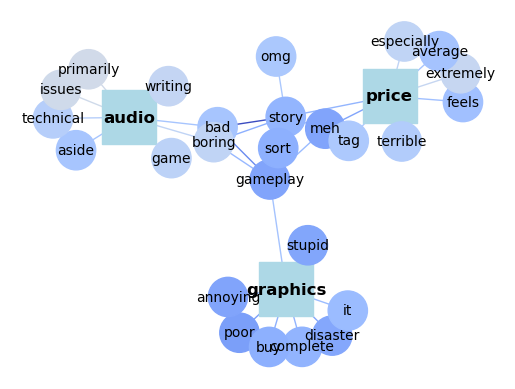

Total Elapsed time: 3.60 seconds


In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS
from textblob import TextBlob
import timeit
start_time = timeit.default_timer()
# Load the data

# Add your list of keyword topics
# keywords = ['gameplay', 'performance', 'graphics','story','audio','price']
keywords = ['gameplay','graphics','story','audio','price']
keywords = ['gameplay','graphics','story','audio','price']
# Preprocessing the reviews
def preprocess_review(review):
    return ' '.join([word.lower() for word in review.split() if word.lower() not in STOPWORDS])

reviews_df['processed_review'] = reviews_df['review'].apply(preprocess_review)

pattern = r'[^a-zA-Z0-9\s]+'
reviews_df['processed_review'] = reviews_df['processed_review'].apply(lambda x: re.sub(pattern, '', x))


# Creating a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(reviews_df['processed_review'])

# Function to get the top relevant words
def get_top_relevant_words(keyword, n=8):
    keyword_tfidf = vectorizer.transform([keyword])
    cosine_sim_matrix = cosine_similarity(keyword_tfidf, tfidf_matrix)
    sentiment_scores = [TextBlob(review).sentiment.polarity for review in reviews_df['processed_review']]
    
    sorted_indices = np.argsort(cosine_sim_matrix * sentiment_scores)[::-1]
    top_n_reviews = [reviews_df.iloc[i]['processed_review'] for i in sorted_indices.flatten()[:n]]
    top_n_words = [word for review in top_n_reviews for word in review.split() if word != keyword]  # Exclude the keyword itself
    top_n_sentiments = [sentiment_scores[i] for i in sorted_indices.flatten()[:n]]

    return list(zip(top_n_words, top_n_sentiments))


# Create the graph
G = nx.Graph()

# Add the keyword nodes
for keyword in keywords:
    G.add_node(keyword, color='blue', node_type='keyword')

# Add the top relevant words nodes and edges
for keyword in keywords:
    top_words_sentiments = get_top_relevant_words(keyword)
    for word, sentiment in top_words_sentiments:
        color = plt.cm.coolwarm((sentiment + 1) / 2)  # Convert sentiment score to color
        G.add_node(word, color=color, node_type='word')
        G.add_edge(keyword, word, color=color)

# Draw the graph
pos = nx.spring_layout(G, seed=42, k=0.7, iterations=100)

# Keyword and word nodes separation
keyword_nodes = [node for node, attr in G.nodes(data=True) if attr['node_type'] == 'keyword']
word_nodes = [node for node, attr in G.nodes(data=True) if attr['node_type'] == 'word']

# Colors
colors = [attr['color'] for node, attr in G.nodes(data=True) if node in word_nodes]
edge_colors = [attr['color'] for _, _, attr in G.edges(data=True)]

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=keyword_nodes, node_color='lightblue', node_shape='s', node_size=1500)
nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color=colors, node_shape='o', node_size=800)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color=edge_colors)

# Draw labels
keyword_labels = {node: {'label': node, 'font_weight': 'bold', 'font_size': 12, 'color': 'black'} for node in keyword_nodes}
word_labels = {node: {'label': node, 'font_weight': 'normal', 'font_size': 10, 'color': 'black'} for node in word_nodes}
labels = {**keyword_labels, **word_labels}

for node, label_data in labels.items():
    nx.draw_networkx_labels(G, pos, labels={node: label_data['label']}, font_size=label_data['font_size'], font_weight=label_data['font_weight'], font_color=label_data['color'])

# Show plot
plt.axis('off')
plt.show()
elapsed_time = timeit.default_timer() - start_time
print(f"Total Elapsed time: {elapsed_time:.2f} seconds")

In [3]:
def get_pros_and_cons(keyword, n=4):
    keyword_tfidf = vectorizer.transform([keyword])
    cosine_sim_matrix = cosine_similarity(keyword_tfidf, tfidf_matrix)
    sentiment_scores = [TextBlob(review).sentiment.polarity for review in reviews_df['processed_review']]
    
    sorted_indices = np.argsort(cosine_sim_matrix * sentiment_scores)[::-1]
    positive_indices = [i for i in sorted_indices.flatten() if sentiment_scores[i] > 0]
    negative_indices = [i for i in sorted_indices.flatten() if sentiment_scores[i] < 0]
    
    top_positive_reviews = [reviews_df.iloc[i]['processed_review'] for i in positive_indices[:n]]
    top_negative_reviews = [reviews_df.iloc[i]['processed_review'] for i in negative_indices[:n]]
    
    top_positive_words = [word for review in top_positive_reviews for word in review.split() if word != keyword]
    top_negative_words = [word for review in top_negative_reviews for word in review.split() if word != keyword]

    return top_positive_words, top_negative_words


In [4]:
for keyword in keywords:
    pros, cons = get_pros_and_cons(keyword)
    print(f"{keyword.capitalize()} Pros: {pros}")
    print(f"{keyword.capitalize()} Cons: {cons}\n")


Gameplay Pros: ['listen', 'negative', 'reviews', 'gamedownload', 'demo', 'see', 'first', 'game', 'deserve', 'crap', 'gets', 'actually', 'fun', 'gameone', 'better', 'games', 'released', 'last', 'six', 'months', 'im', 'highly', 'enjoying', 'hope', 'others', 'sure', 'bugs', 'game', 'now', 'writing', 'ok', 'play', 'games', 'game', 'play', 'please', 'try', 'open', 'mind', 'disregard', 'bad', 'reviews', 'see', 'play', 'sqaure', 'great', 'job', 'one', 'hope', 'bring', 'game', 'deserve', 'hate', 'train', 'getting', '1', 'enjoy', 'infamous', 'style', 'combat', 'want', 'modern', 'version', 'beautiful', 'graphics', 'fast', 'skill', 'based', 'combat', 'high', 'freedom', 'mobility', 'game', 'really', 'great', 'real', 'power', 'trip', 'master', 'system', 'time2', 'apparently', 'people', 'dislike', 'dialogue', 'enjoy', 'quippy', 'buddy', 'cop', 'style', 'banter', 'specifically', 'uncharted', 'series', 'will', 'likely', 'enjoy', 'writer', 'uncharted', '3', 'central', 'hub', 'city', 'return', 'explorat

Price Pros: ['editing', 'review', 'still', 'recommend', 'major', 'flaws', 'game', 'wait', 'sale', 'try', 'demo', 'think', 'demo', 'good', 'started', 'point', 'performance', 'may', 'still', 'issues', 'areasi', 'think', 'strong', 'start', 'unlike', 'others', 'genuinely', 'liked', 'protagonist', 'found', 'experience', 'personality', 'work', 'really', 'well', 'early', 'story', 'think', 'lot', 'people', 'saying', 'overly', 'abrasive', 'cringey', 'likely', 'opinions', 'framed', 'others', 'hard', 'to', 'nearly', 'everyone', 'seems', 'hate', 'everything', 'says', 'particular', 'thoughtful', 'character', 'either', 'sometimes', 'little', 'rough', 'will', 'give', 'credit', 'think', 'set', 'difficult', 'character', 'write', 'empty', 'world', 'character', 'deeply', 'reliant', 'external', 'influences', 'drive', 'actions', 'will', 'add', 'problems', 'game', 'seeming', 'lose', 'effort', 'game', 'progresses', 'hurt', 'protagonist', 'most', 'given', 'chance', 'evolve', 'way', 'hinted', 'wouldi', 'think'

False

In [13]:
pip install gensim==3.8.3

     --------------------------------------- 23.4/23.4 MB 81.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-win_amd64.whl size=24155958 sha256=d2dd0270b6aebf80c0dd1434bcfbb057f4c241ae2746d665a3fd06a4e89f156a
  Stored in directory: c:\users\tbont\appdata\local\pip\cache\wheels\ca\5d\af\618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1
Note: you may need to restart the kernel to use updated packages.


In [29]:
from gensim.summarization.summarizer import summarize
# Summarize reviews
def summarize_reviews(reviews, ratio=0.1):
    concatenated_reviews = '\n'.join(reviews)
    summary = summarize(concatenated_reviews, ratio=ratio)
    return summary

# summary = summarize_reviews(reviews_df['review'])
summary = summarize_reviews(nr_df['review'])
print("Summary of Reviews:")
print(summary)

Summary of Reviews:
I'm almost done with the game and I feel like I've played it enough to give it a review.
There could be more, but the devs said that the story was around 15 hours "Forspoken's length should take players about 10-15 hours if you are solely focused on the main story, with a completionist playthrough taking closer to 30 to 40 hours to complete.Forspoken's length should take players about 10-15 hours if you are solely focused on the main story, with a completionist playthrough taking closer to 30 to 40 hours to complete." - And for the 10 hours thing, halfway through I decided I didn't care for the story and started skipping dialogue, I didn't care for the characters and I got where the story was going pretty quickly so I just didn't watch it and played the game.
I enjoy the combat more than anything and just wanted to do some cool moves and fight.Also, I don't like side-quests in games generally, I will try a few if I need to level up more or need some resources, but, 

In [15]:
from collections import Counter
from string import punctuation
from heapq import nlargest
#Import if not already imported:
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords

In [16]:
# code compute the word frequencies

STOPWORDS = set(stopwords.words('english') + list(punctuation))
MIN_WORD_PROP, MAX_WORD_PROP = 0.1, 0.9

def compute_word_frequencies(word_sentences):
  words = [word for sentence in word_sentences for word in sentence if word not in STOPWORDS]
  counter = Counter(words)
  limit = float(max(counter.values()))
  word_frequencies = {word: freq/limit for word,freq in counter.items()}
  
  # Drop words if too common or too uncommon
  word_frequencies = {word: freq 
                      for word,freq in word_frequencies.items() 
                      if freq > MIN_WORD_PROP and freq < MAX_WORD_PROP}
  return word_frequencies

In [17]:
# score each sentence by how frequent the words in it are

def sentence_score(word_sentence, word_frequencies):
  return sum([ word_frequencies.get(word,0) for word in word_sentence])

In [30]:
# implement the summarize() function
# returns the top three sentences ranked by word frequency
# :text the text to summarize
# :num_sentences the number of sentences to return

def summarize(text:str, num_sentences=3):
  # Make the text lowercase
  text = text.lower()

  # Break text into sentences
  sentences = sent_tokenize(text)

  # Break sentences into words
  word_sentences = [word_tokenize(sentence) for sentence in sentences]

  # Compute the word frequencies
  word_frequencies = compute_word_frequencies(word_sentences)

  # Calculate the scores for each of the sentences
  scores = [sentence_score(word_sentence, word_frequencies) for word_sentence in word_sentences]
  sentence_scores = list(zip(sentences, scores))

  # Rank the sentences
  top_sentence_scores = nlargest(num_sentences, sentence_scores, key=lambda t: t[1])

  # Return the top sentences
  return [t[0] for t in top_sentence_scores]


In [31]:
summarize(summary)


['cons - the writing is bland, they freeze you in place randomly for dialog - the npcs are the most annoying people / the bracelet talks way too much  - bad voice acting - characters stand still and have no emotions like robots - world is somewhat empty other than random chests to open - the crafting is really basic even though there are skills to spend mana on to craft more crafting materials - it\'s a bad port/is optimized poorly (running a 5900x and 3080ti, on high i run 70fps with nothing going on and ~30fps when anything is moving)  - it\'s does not feel like a $70 game, should be 30 or 40 - it\'s a short game from what i have heard - does not at all look like what the trailers looked like - parkour part is frustrating and okay at the best of times - not truely open world, most of the time it will tell you that you are too far away from the objective and teleports you back not allowing you to explore - it forces you to walk super slow in some parts for "reasons" - combat is boring

In [33]:
summarize(summary, num_sentences=1)

['cons - the writing is bland, they freeze you in place randomly for dialog - the npcs are the most annoying people / the bracelet talks way too much  - bad voice acting - characters stand still and have no emotions like robots - world is somewhat empty other than random chests to open - the crafting is really basic even though there are skills to spend mana on to craft more crafting materials - it\'s a bad port/is optimized poorly (running a 5900x and 3080ti, on high i run 70fps with nothing going on and ~30fps when anything is moving)  - it\'s does not feel like a $70 game, should be 30 or 40 - it\'s a short game from what i have heard - does not at all look like what the trailers looked like - parkour part is frustrating and okay at the best of times - not truely open world, most of the time it will tell you that you are too far away from the objective and teleports you back not allowing you to explore - it forces you to walk super slow in some parts for "reasons" - combat is boring